
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [3]:

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [4]:
asset = 'AAPL'
ticker = 'AAPL'
start_date = "2015-01-01"
end_date = "2024-01-01"

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
prices = data['Adj Close']

# Filling missing values / rows
full_range = pd.date_range(prices.index.min(), prices.index.max(), freq="B")
prices_full = prices.reindex(full_range).ffill().bfill()
prices = prices_full[asset]

[*********************100%***********************]  1 of 1 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [7]:
# daily log returns
returns = np.log(prices / prices.shift(1))
returns = returns.dropna()

features = pd.DataFrame(index=returns.index)

# r_t
features["r_t"] = returns

# r_{t-1}
features["r_t_minus_1"] = returns.shift(1)

# 20-day rolling mean
features["roll_mean_20"] = returns.rolling(window=20).mean()

# 20-day rolling volatility
features["roll_vol_20"] = returns.rolling(window=20).std()

# 5-day momentum
features["momentum_5"] = returns.rolling(window=5).sum()

In [11]:
#training data preparation
target = returns.shift(-1)

dataset = features.copy()
dataset["target"] = target

# remove NaNs
dataset = dataset.dropna()


## 4. Naive baselines


In [12]:
zero_pred = np.zeros(len(dataset))

In [13]:
rolling_mean_pred = dataset["roll_mean_20"].values


## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [23]:
# use LinearRegression from sklearn
from sklearn.linear_model import Ridge
linear_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)


## 6. Tree-based model (Random Forest) (optional)


In [22]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)

## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [24]:
X = dataset[[
    "r_t",
    "r_t_minus_1",
    "roll_mean_20",
    "roll_vol_20",
    "momentum_5"
]].values

y = dataset["target"].values

In [45]:
tscv = TimeSeriesSplit(n_splits=5)
y_pred_lr = []
y_pred_ridge = []
y_pred_rf = []
y_pred_zero = []
y_pred_roll = []
true_y_list = []
test_dates = []

In [46]:
for train_index, test_index in tscv.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_dates.extend(dataset.index[test_index])
    
    # Linear Regression (OLS)
    linear_model.fit(X_train, y_train)
    y_pred_lr.extend(linear_model.predict(X_test))
    
    # Ridge Regression
    ridge_model.fit(X_train, y_train)
    y_pred_ridge.extend(ridge_model.predict(X_test))
    
    # Random Forest
    rf.fit(X_train, y_train)
    y_pred_rf.extend(rf.predict(X_test))
    
    # Zero baseline
    y_pred_zero.extend(np.zeros(len(y_test)))
    
    # Rolling mean baseline
    y_pred_roll.extend(dataset["roll_mean_20"].iloc[test_index])
    
    true_y_list.extend(y_test)



## 8. Prediction accuracy


In [47]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_zero = rmse(true_y_list, y_pred_zero)
rmse_roll = rmse(true_y_list, y_pred_roll)
rmse_lr = rmse(true_y_list, y_pred_lr)
rmse_ridge = rmse(true_y_list, y_pred_ridge)
rmse_rf = rmse(true_y_list, y_pred_rf)

In [48]:
print("RMSE Comparison (lower is better):\n")

print(f"Zero-return predictor   : {rmse_zero:.6f}")
print(f"Rolling mean predictor  : {rmse_roll:.6f}")
print(f"Linear Regression (OLS) : {rmse_lr:.6f}")
print(f"Ridge Regression        : {rmse_ridge:.6f}")
print(f"Random Forest           : {rmse_rf:.6f}")

RMSE Comparison (lower is better):

Zero-return predictor   : 0.018284
Rolling mean predictor  : 0.018631
Linear Regression (OLS) : 0.018386
Ridge Regression        : 0.018290
Random Forest           : 0.018277


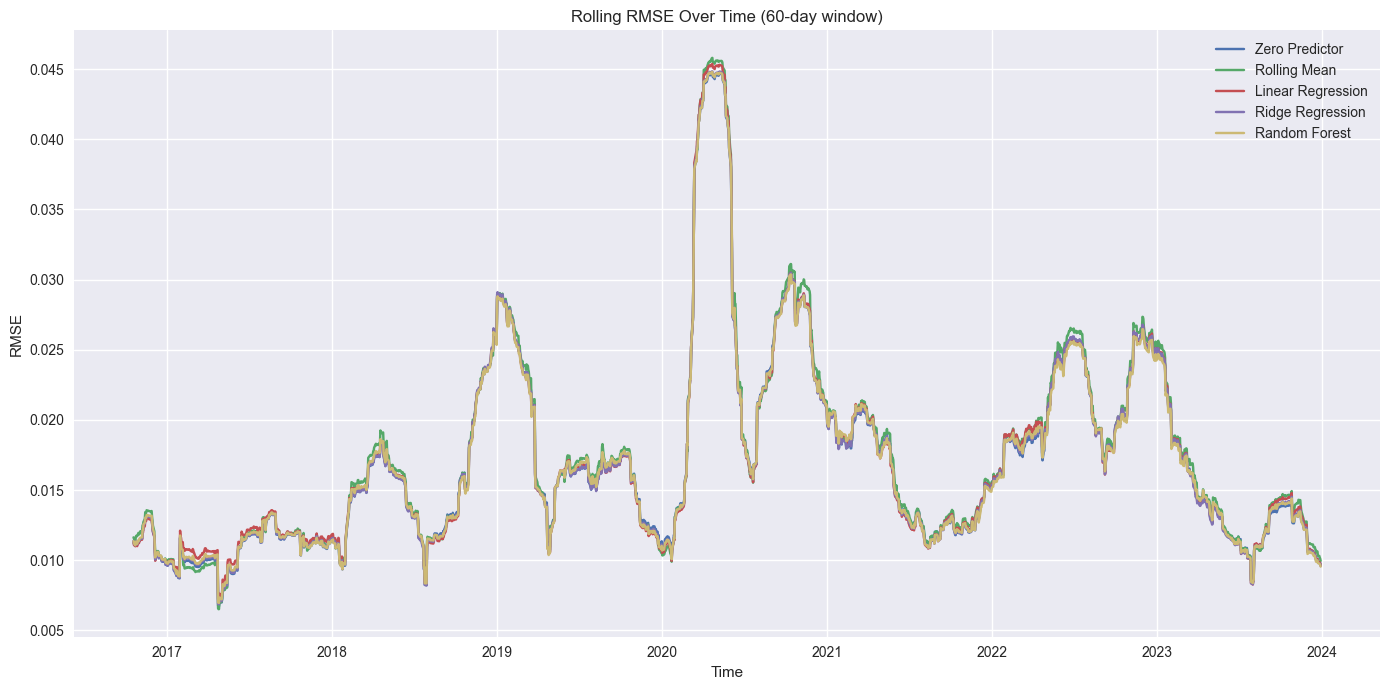

In [51]:
results_df = pd.DataFrame(
    {
        "true": true_y_list,
        "zero": y_pred_zero,
        "roll_mean": y_pred_roll,
        "linear": y_pred_lr,
        "ridge": y_pred_ridge,
        "rf": y_pred_rf
    },
    index=pd.to_datetime(test_dates)
)

results_df = results_df.sort_index()

window = 60

rolling_rmse = pd.DataFrame(index=results_df.index)

for model in ["zero", "roll_mean", "linear", "ridge", "rf"]:
    rolling_rmse[model] = (
        (results_df[model] - results_df["true"])**2
    ).rolling(window).mean().pow(0.5)

plt.figure(figsize=(14, 7))

plt.plot(rolling_rmse.index, rolling_rmse["zero"], label="Zero Predictor")
plt.plot(rolling_rmse.index, rolling_rmse["roll_mean"], label="Rolling Mean")
plt.plot(rolling_rmse.index, rolling_rmse["linear"], label="Linear Regression")
plt.plot(rolling_rmse.index, rolling_rmse["ridge"], label="Ridge Regression")
plt.plot(rolling_rmse.index, rolling_rmse["rf"], label="Random Forest")

plt.title("Rolling RMSE Over Time (60-day window)")
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [52]:
vol_t = dataset.loc[test_dates, "roll_vol_20"].values

# avoid division by zero
vol_t = np.where(vol_t == 0, np.nan, vol_t)
y_true = np.array(true_y_list)

norm_err = {
    "Zero Predictor": np.nanmean(np.abs(y_true - y_pred_zero) / vol_t),
    "Rolling Mean": np.nanmean(np.abs(y_true - y_pred_roll) / vol_t),
    "Linear Regression": np.nanmean(np.abs(y_true - y_pred_lr) / vol_t),
    "Ridge Regression": np.nanmean(np.abs(y_true - y_pred_ridge) / vol_t),
    "Random Forest": np.nanmean(np.abs(y_true - y_pred_rf) / vol_t),
}

print("Comparison of models (highest to lowest normalized prediction error):")
for model, score in sorted(norm_err.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.6f}")

Comparison of models (highest to lowest normalized prediction error):
Rolling Mean: 0.832926
Linear Regression: 0.817039
Random Forest: 0.811999
Ridge Regression: 0.806677
Zero Predictor: 0.805558


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [1]:
# TODO: compute the positions for each model and daily returns


In [ ]:
# TODO: plot your returns


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?